# Relational Match-to-Sample (RMTS): Relational Neural Networks (Grouping Layer)

## Set Up

In [1]:
import os
import itertools

import numpy as np

import sklearn.model_selection
import sklearn.metrics

from tqdm.auto import tqdm

import wandb

import tensorflow as tf


# %load_ext autoreload
# %autoreload 2
import sys; sys.path.append('..')

from relational_neural_networks.relational_neural_networks import *
from relational_neural_networks.utils import *

## Generate Dataset for "Relational Match to Sample" Task

**Description of Task**: There exists 4 different possible objects, call them $\{A, B, C, D\}$. The player is first given a 2-tuple of the objects, where the objects either match or don't (i.e.: of the form either $AA$ or $AB$). The player is then given two other 2-tuples of objects, one of them where the objects match and one where they do not (e.g.: the tuples $CC$ and $CB$). The player must then choose the option that matches the relation in the first 2-tuple. For example, if the first 2-tuple is $BC$, and the two options are (1) $AA$ and (2) $BD$, the player should choose (2).

In [2]:
entities = ['A', 'B', 'C', 'D']
encoded_entities = [(0,0,0,1), (0,0,1,0), (0,1,0,0), (1,0,0,0)]
encoding_dict = dict(zip(entities, encoded_entities))

def generate_data_point(first_is_match, encoded=False):

    options = entities

    # first 2-tuple is a 'match'
    if first_is_match:
        o1 = np.random.choice(options)
        x1 = (o1, o1)
    # first 2-tuple is not a match
    else:
        o1, o2 = np.random.choice(options, size=2, replace=False)
        x1 = (o1, o2)

    same_o = np.random.choice(options)
    same_option = (same_o, same_o)

    diff_o1, diff_o2 = np.random.choice(options, size=2, replace=False)
    diff_option = (diff_o1, diff_o2)

    if np.random.random() < 0.5:
        x = (*x1, *same_option, *diff_option)
        first_is_match = 0 if first_is_match else 1
    else:
        x = (*x1, *diff_option, *same_option)
        first_is_match = 1 if first_is_match else 0

    if encoded:
        x = tuple(encoding_dict[x_] for x_ in x)

    return x, first_is_match

class_names = ['match first', 'match second']

In [3]:
# generate some sample data

print('match')
for _ in range(5):
    x, y = generate_data_point(1)
    print(f'x = {tuple(tuple(x[i:i+2]) for i in range(0,len(x),2))}; y = {y}')

print()
print('non-match')
for _ in range(5):
    x, y = generate_data_point(0)
    print(f'x = {tuple(tuple(x[i:i+2]) for i in range(0,len(x),2))}; y = {y}')

match
x = (('C', 'C'), ('A', 'A'), ('A', 'C')); y = 0
x = (('B', 'B'), ('C', 'D'), ('C', 'C')); y = 1
x = (('B', 'B'), ('B', 'A'), ('C', 'C')); y = 1
x = (('B', 'B'), ('C', 'D'), ('A', 'A')); y = 1
x = (('C', 'C'), ('C', 'B'), ('A', 'A')); y = 1

non-match
x = (('C', 'D'), ('C', 'A'), ('D', 'D')); y = 0
x = (('C', 'B'), ('C', 'A'), ('C', 'C')); y = 0
x = (('B', 'A'), ('D', 'C'), ('A', 'A')); y = 0
x = (('A', 'B'), ('A', 'A'), ('A', 'B')); y = 1
x = (('B', 'A'), ('B', 'B'), ('D', 'B')); y = 1


In [4]:
n_samples = int(1e4)
X = []
y = []

for is_same in tqdm(np.random.randint(0, 2, size=n_samples)):
    x_, y_ = generate_data_point(is_same, encoded=True)
    X.append(x_)
    y.append(y_)

X = np.array(X, dtype=float)
y = np.array(y, dtype=float)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [5]:
# split training, validation, and testing sets
test_size = 0.4
val_size = 0.1

train_idx, test_idx = sklearn.model_selection.train_test_split(range(len(y)), test_size=test_size, stratify=y)
X_test = X[test_idx]
y_test = y[test_idx]

y_train = y[train_idx]

train_idx, val_idx = sklearn.model_selection.train_test_split(train_idx, test_size=val_size/(1-test_size), stratify=y_train)

X_train = X[train_idx]
y_train = y[train_idx]
X_val = X[val_idx]
y_val = y[val_idx]

y_train = tf.one_hot(y_train, 2)
y_val = tf.one_hot(y_val, 2)
y_test = tf.one_hot(y_test, 2)

# create tensorflow datasets
batch_size = 128
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

## Models

In [6]:
# define common components across models

def create_callbacks():
    callbacks = [
        # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='auto', restore_best_weights=True),
        # tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto'),
        wandb.keras.WandbCallback(
            monitor="val_loss", log_weights=True, log_gradients=True, save_model=False, save_graph=True,
            training_data=train_ds, validation_data=val_ds,
            labels=class_names, predictions=64, compute_flops=True)
        ]
    return callbacks

metrics = [
        tf.keras.metrics.BinaryAccuracy(name='acc'),
        tf.keras.metrics.Precision(class_id=1, name='precision'),
        tf.keras.metrics.Recall(class_id=1, name='recall'),
        tf.keras.metrics.AUC(curve='ROC', multi_label=True, name='auc')
        ]

loss = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
fit_kwargs = {'epochs': 50, 'shuffle': True}


def eval_metrics(model):

    print('test set')
    pred_proba_test = model.predict(test_ds)
    pred_test = np.argmax(pred_proba_test, axis=1)
    print(sklearn.metrics.classification_report(y_test[:,1], pred_test))

    return pred_proba_test, pred_test

def log_to_wandb(y_test, pred_proba_test, pred_test):
    # log test-set metrics to W&B
    y_test = np.array(y_test[:,1])
    wandb.log({"pr": wandb.plot.pr_curve(y_test, pred_proba_test, class_names)})
    wandb.log({"roc": wandb.plot.roc_curve(y_test, pred_proba_test, labels=class_names)})
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(y_true=y_test, preds=pred_test, class_names=class_names)})

In [7]:
# set up W&B logging
%load_ext dotenv
%dotenv

%env "WANDB_NOTEBOOK_NAME" "rmts-group-experiments.ipynb"

import wandb
wandb.login(key=os.environ['WANDB_API_KEY'])

env: "WANDB_NOTEBOOK_NAME"="rmts-group-experiments.ipynb"


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: awni00. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\awnya/.netrc


True

### Non-relational model (MLP)

In [8]:
run = wandb.init(project='RelNN-RMTS', group='Non-Relational MLP', save_code=True)
input_ = tf.keras.layers.Input(shape=(6, 4), name='input_seq')

x = tf.keras.layers.Flatten()(input_)
x = tf.keras.layers.Dense(32, activation='relu', name='dense1')(x)
x = tf.keras.layers.Dense(16, activation='relu', name='dense2')(x)
x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

model = tf.keras.Model(input_, x, name='nonrelational_MLP')

model.compile(loss=loss, optimizer=opt, metrics=metrics)

history = model.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), **fit_kwargs)

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Epoch 1/50
40/40 [==============================] - 6s 112ms/step - loss: 0.6945 - acc: 0.5275 - precision: 0.5278 - recall: 0.4743 - auc: 0.5344 - val_loss: 0.6855 - val_acc: 0.5684 - val_precision: 0.6130 - val_recall: 0.3594 - val_auc: 0.5900
Epoch 2/50
40/40 [==============================] - 3s 74ms/step - loss: 0.6648 - acc: 0.6263 - precision: 0.6291 - recall: 0.6058 - auc: 0.6651 - val_loss: 0.6452 - val_acc: 0.6733 - val_precision: 0.6552 - val_recall: 0.7249 - val_auc: 0.7023
Epoch 3/50
40/40 [==============================] - 1s 24ms/step - loss: 0.5914 - acc: 0.7149 - precision: 0.7188 - recall: 0.7011 - auc: 0.7764 - val_loss: 0.5312 - val_acc: 0.7662 - val_precision: 0.7640 - val_recall: 0.7671 - val_auc: 0.8302
Epoch 4/50
40/40 [==============================] - 2s 62ms/step - loss: 0.4306 - acc: 0.8366 - precision: 0.8458 - recall: 0.8210 - auc: 0.9031 - val_loss: 0.3235 - val_acc: 

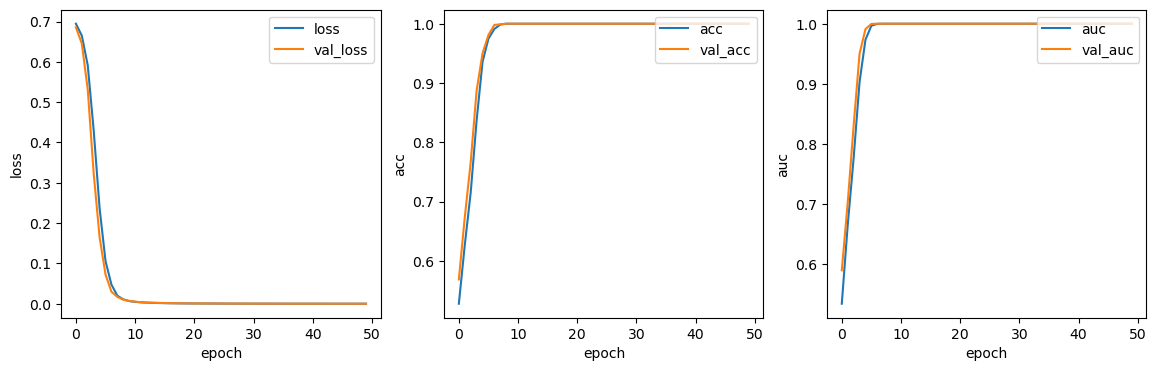

In [9]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [10]:
pred_proba_test, pred_test = eval_metrics(model)

test set
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2010
         1.0       1.00      1.00      1.00      1990

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [11]:
log_to_wandb(y_test, pred_proba_test, pred_test)

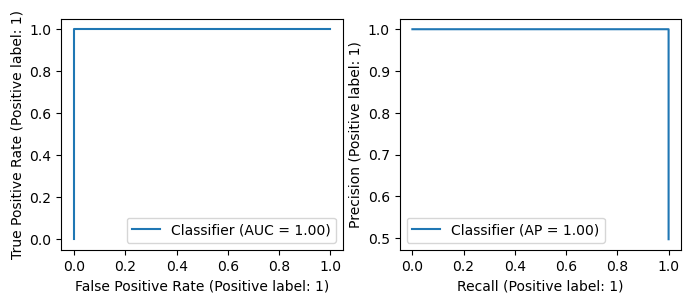

In [12]:
plot_roc_pr_curves(pred_proba_test, y_test[:,1]);

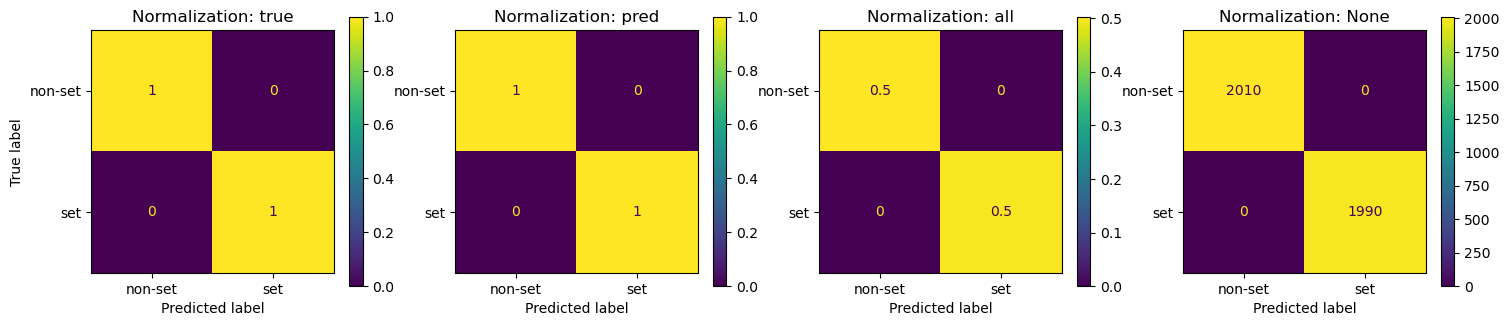

In [13]:
plot_confusion_matrices(y_test[:,1], pred_test);

In [14]:
wandb.finish()

acc,▁▂▄▆████████████████████████████████████
auc,▁▃▅▇████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▇▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▃▄▆████████████████████████████████████
recall,▁▃▄▆▇███████████████████████████████████
val_acc,▁▃▄▆████████████████████████████████████
val_auc,▁▃▅▇████████████████████████████████████
val_loss,██▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▂▄▇████████████████████████████████████
val_recall,▁▅▅▆████████████████████████████████████


### CoRelNet

In [15]:
# Simple CoRelNet with no (additional) encoder; just compute relation matrix and pass to dense layer
run = wandb.init(project='RelNN-RMTS', group='CoRelNet', save_code=True)

input_ = tf.keras.layers.Input(shape=(6, 4), name='input_seq')

rel_inner_prod = RelInnerProduct(name='rel_inner_prod')
x = rel_inner_prod(input_)

x = tf.expand_dims(x, axis=-1)
x = FlattenTriangular(include_diag=False, name='flatten_tri')(x)

x = tf.keras.layers.Dense(16, activation='relu', name='dense1')(x)
x = tf.keras.layers.Dense(8, activation='relu', name='dense2')(x)
x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

model = tf.keras.Model(input_, x, name='CoRelNet')
model.summary()

Model: "CoRelNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_seq (InputLayer)      [(None, 6, 4)]            0         
                                                                 
 rel_inner_prod (RelInnerPro  (None, 6, 6)             0         
 duct)                                                           
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 6, 6, 1)          0         
                                                                 
 flatten_tri (FlattenTriangu  (None, 15)               0         
 lar)                                                            
                                                                 
 dense1 (Dense)              (None, 16)                256       
                                                                 
 dense2 (Dense)              (None, 8)                 136

In [16]:
model.compile(loss=loss, optimizer=opt, metrics=metrics)

history = model.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), **fit_kwargs)

Epoch 1/50
40/40 [==============================] - 5s 99ms/step - loss: 0.2007 - acc: 0.9100 - precision: 0.8980 - recall: 0.9239 - auc: 0.9832 - val_loss: 1.2577e-05 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 2/50
40/40 [==============================] - 2s 56ms/step - loss: 6.3193e-06 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.6752e-06 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/50
40/40 [==============================] - 1s 23ms/step - loss: 2.2010e-06 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9852e-06 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 4/50
40/40 [==============================] - 1s 21ms/step - loss: 1.7692e-06 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.6640e-06 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc:

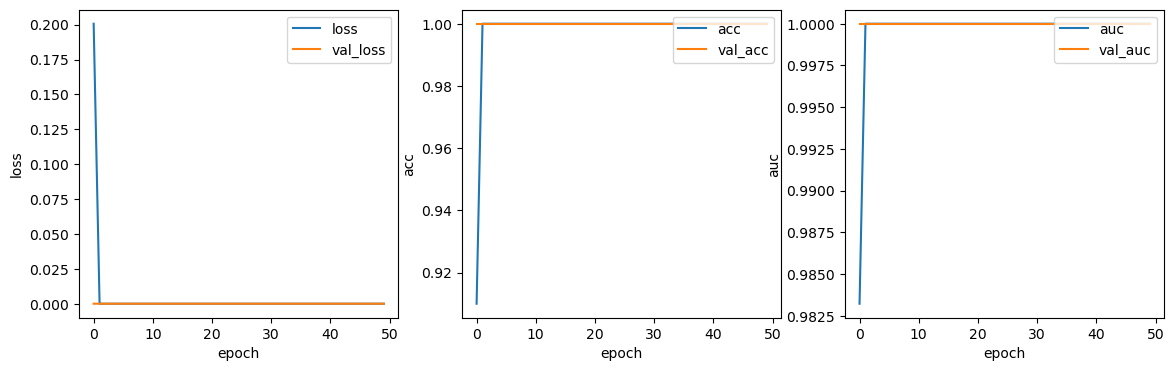

In [17]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [18]:
pred_proba_test, pred_test = eval_metrics(model)

test set
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2010
         1.0       1.00      1.00      1.00      1990

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [19]:
log_to_wandb(y_test, pred_proba_test, pred_test)

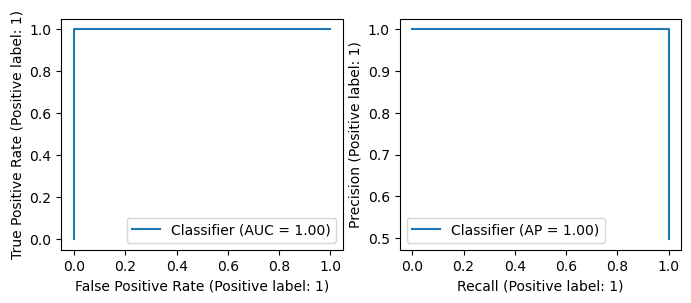

In [20]:
plot_roc_pr_curves(pred_proba_test, y_test[:,1]);

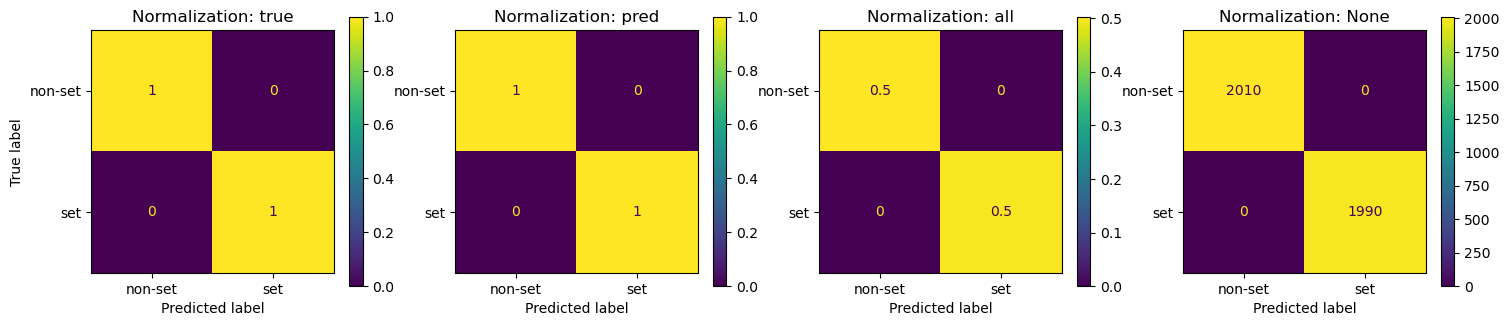

In [21]:
plot_confusion_matrices(y_test[:,1], pred_test);

In [22]:
wandb.finish()

acc,▁███████████████████████████████████████
auc,▁███████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁███████████████████████████████████████
recall,▁███████████████████████████████████████
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_auc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


### RelNN with Grouping Layer (Good init)

In [23]:
run = wandb.init(project='RelNN-RMTS', group='RelNN (w Grouping Layer; good init)', save_code=True)

input_ = tf.keras.layers.Input(shape=(6, 4), name='input_seq')

rel_inner_prod = RelInnerProduct(name='rel_inner_prod')
x = rel_inner_prod(input_)
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), name='expand_dims')(x)

glayer = GroupLayer(num_groups=3, name='group_layer')
x = glayer(x)

x = tf.keras.layers.Flatten(name='flatten')(x)

x = tf.keras.layers.Dense(16, activation='relu', name='dense1')(x)
x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

model = tf.keras.Model(input_, x, name='RelNN_w_Grouping')

my_logits = [
  np.transpose([[1, 1, -1, -1, -1, -1]]),
  np.transpose([[-1, -1, 1, 1, -1, -1]]),
  np.transpose([[-1, -1, -1, -1, 1, 1]])
]

glayer.set_weights(my_logits)


model.summary()

Model: "RelNN_w_Grouping"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_seq (InputLayer)      [(None, 6, 4)]            0         
                                                                 
 rel_inner_prod (RelInnerPro  (None, 6, 6)             0         
 duct)                                                           
                                                                 
 expand_dims (Lambda)        (None, 6, 6, 1)           0         
                                                                 
 group_layer (GroupLayer)    (None, 3, 1)              18        
                                                                 
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense1 (Dense)              (None, 16)                64        
                                                  

In [24]:
model.compile(loss=loss, optimizer=opt, metrics=metrics)

history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=create_callbacks(), **fit_kwargs)

Epoch 1/10
40/40 [==============================] - 26s 98ms/step - loss: 0.6964 - acc: 0.5950 - precision: 0.5983 - recall: 0.5650 - auc: 0.6683 - val_loss: 0.6400 - val_acc: 0.7552 - val_precision: 1.0000 - val_recall: 0.5080 - val_auc: 0.6573
Epoch 2/10
40/40 [==============================] - 0s 10ms/step - loss: 0.4919 - acc: 0.7772 - precision: 0.9751 - recall: 0.5664 - auc: 0.8740 - val_loss: 0.2261 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/10
40/40 [==============================] - 0s 10ms/step - loss: 0.0740 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0185 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 4/10
40/40 [==============================] - 0s 11ms/step - loss: 0.0122 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0081 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 5/10
40/40 [=

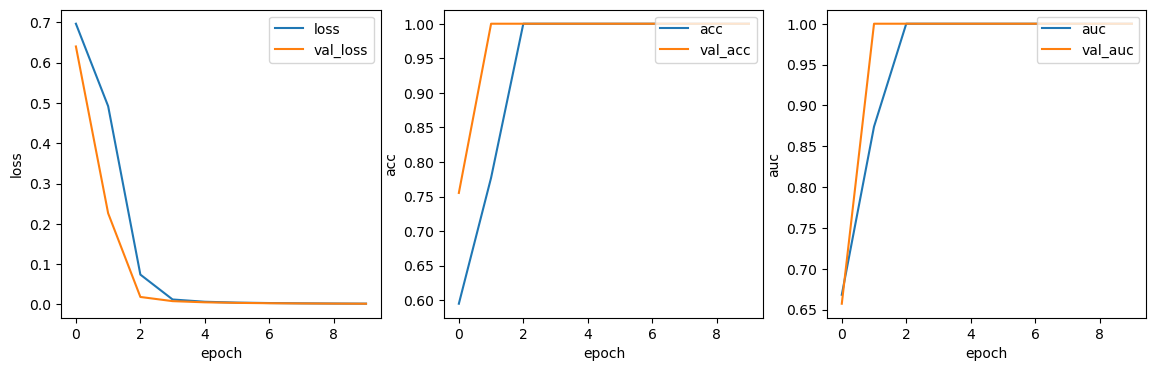

In [25]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [26]:
pred_proba_test, pred_test = eval_metrics(model)

test set
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2010
         1.0       1.00      1.00      1.00      1990

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [27]:
log_to_wandb(y_test, pred_proba_test, pred_test)

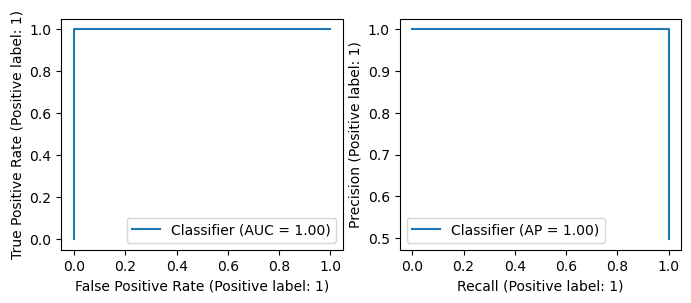

In [28]:
plot_roc_pr_curves(pred_proba_test, y_test[:,1]);

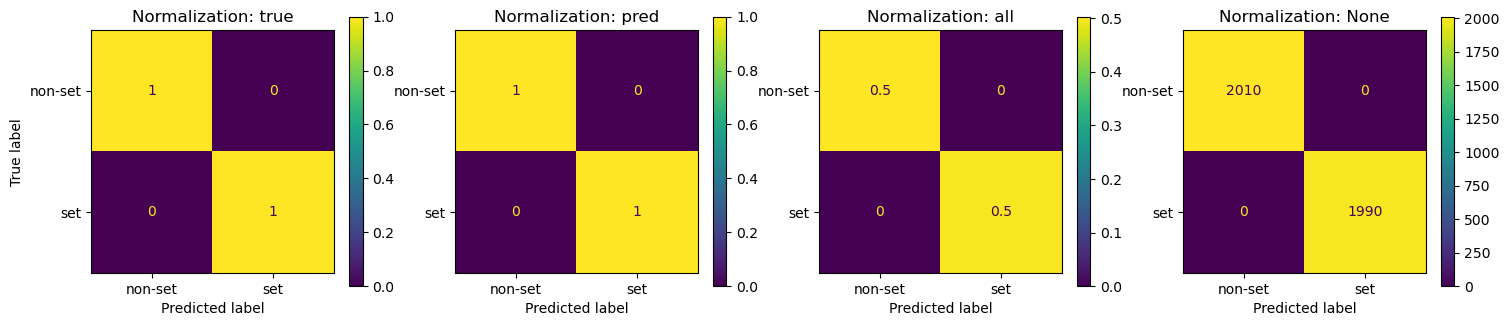

In [29]:
plot_confusion_matrices(y_test[:,1], pred_test);

In [30]:
wandb.finish()

In [31]:
# examine learned groups
glayer.weights

[<tf.Variable 'group_layer/group_0_logit:0' shape=(6, 1) dtype=float32, numpy=
 array([[ 3.1093278],
        [ 3.1092658],
        [-2.645593 ],
        [-2.8754728],
        [-3.1719825],
        [-3.136222 ]], dtype=float32)>,
 <tf.Variable 'group_layer/group_1_logit:0' shape=(6, 1) dtype=float32, numpy=
 array([[-2.5571356],
        [-2.7456038],
        [ 2.66979  ],
        [ 2.6702151],
        [-2.6666083],
        [-2.8352444]], dtype=float32)>,
 <tf.Variable 'group_layer/group_2_logit:0' shape=(6, 1) dtype=float32, numpy=
 array([[-2.8676102],
        [-2.700949 ],
        [-2.2333698],
        [-2.2707453],
        [ 2.5637162],
        [ 2.5608063]], dtype=float32)>]

### RelNN with Grouping (bad init)

In [32]:
run = wandb.init(project='RelNN-RMTS', group='RelNN (w Grouping Layer; bad init)', save_code=True)

input_ = tf.keras.layers.Input(shape=(6, 4), name='input_seq')

rel_inner_prod = RelInnerProduct(name='rel_inner_prod')
x = rel_inner_prod(input_)
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), name='expand_dims')(x)

glayer = GroupLayer(num_groups=3, name='group_layer')
x = glayer(x)

x = tf.keras.layers.Flatten(name='flatten')(x)

x = tf.keras.layers.Dense(16, activation='relu', name='dense1')(x)
x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

model = tf.keras.Model(input_, x, name='RelNN_w_Grouping')

my_logits = [
  np.transpose([[1, -1, 1, -1, -1, -1]]),
  np.transpose([[-1, 1, -1, 1, -1, -1]]),
  np.transpose([[-1, -1, -1, 1, 1, 1]])
]

glayer.set_weights(my_logits)


model.summary()

Model: "RelNN_w_Grouping"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_seq (InputLayer)      [(None, 6, 4)]            0         
                                                                 
 rel_inner_prod (RelInnerPro  (None, 6, 6)             0         
 duct)                                                           
                                                                 
 expand_dims (Lambda)        (None, 6, 6, 1)           0         
                                                                 
 group_layer (GroupLayer)    (None, 3, 1)              18        
                                                                 
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense1 (Dense)              (None, 16)                64        
                                                  

In [33]:
model.compile(loss=loss, optimizer=opt, metrics=metrics)

history = model.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), **fit_kwargs)

Epoch 1/50
40/40 [==============================] - 51s 885ms/step - loss: 0.6853 - acc: 0.6233 - precision: 0.6340 - recall: 0.5741 - auc: 0.6930 - val_loss: 0.6534 - val_acc: 0.6004 - val_precision: 0.7816 - val_recall: 0.2731 - val_auc: 0.7890
Epoch 2/50
40/40 [==============================] - 1s 28ms/step - loss: 0.6443 - acc: 0.6163 - precision: 0.7107 - recall: 0.3854 - auc: 0.6751 - val_loss: 0.5970 - val_acc: 0.6833 - val_precision: 0.7623 - val_recall: 0.5281 - val_auc: 0.8150
Epoch 3/50
40/40 [==============================] - 3s 86ms/step - loss: 0.5727 - acc: 0.6785 - precision: 0.7104 - recall: 0.5969 - auc: 0.8058 - val_loss: 0.5200 - val_acc: 0.6863 - val_precision: 0.7690 - val_recall: 0.5281 - val_auc: 0.8689
Epoch 4/50
40/40 [==============================] - 2s 38ms/step - loss: 0.5085 - acc: 0.7319 - precision: 0.7426 - recall: 0.7056 - auc: 0.8473 - val_loss: 0.4666 - val_acc: 0.7632 - val_precision: 0.7881 - val_recall: 0.7169 - val_auc: 0.8689
Epoch 5/50
40/40 [

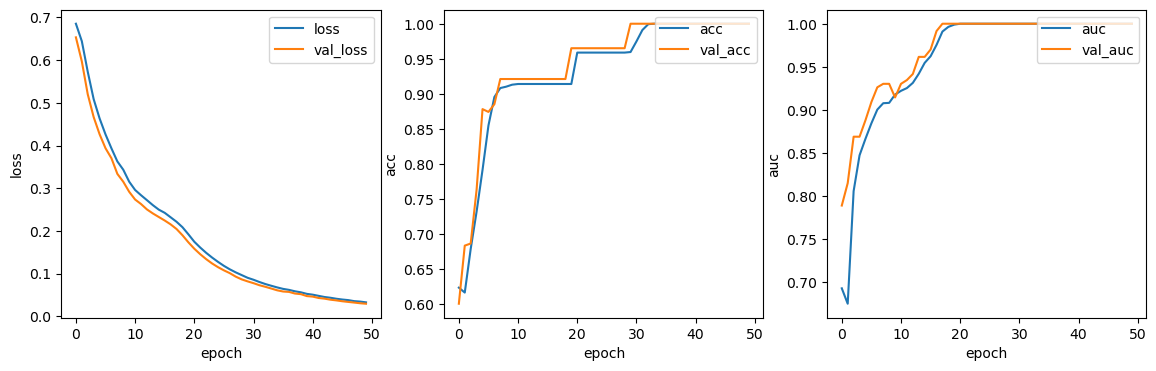

In [34]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [35]:
pred_proba_test, pred_test = eval_metrics(model)

test set
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2010
         1.0       1.00      1.00      1.00      1990

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [36]:
log_to_wandb(y_test, pred_proba_test, pred_test)

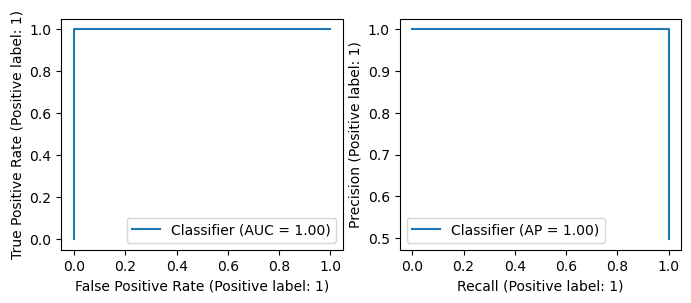

In [37]:
plot_roc_pr_curves(pred_proba_test, y_test[:,1]);

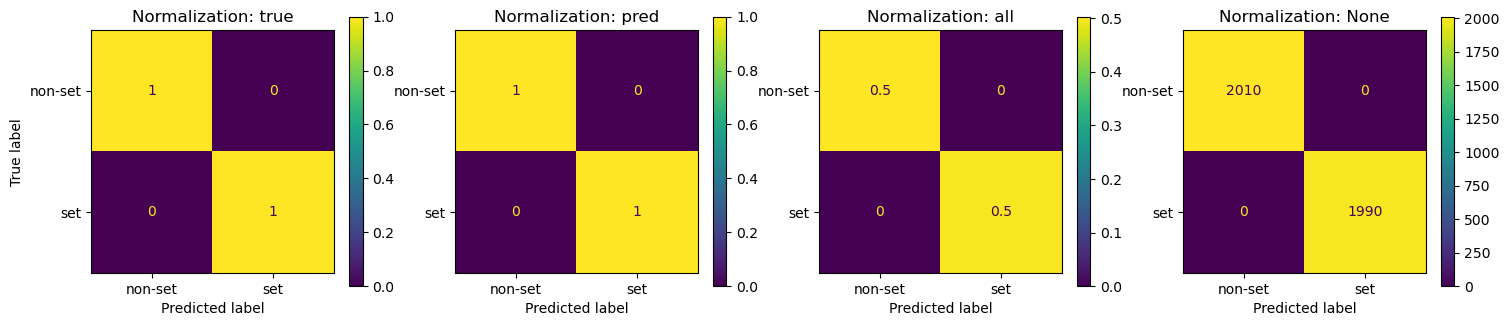

In [38]:
plot_confusion_matrices(y_test[:,1], pred_test);

In [39]:
wandb.finish()

acc,▁▁▂▃▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████████
auc,▁▁▄▅▆▆▆▆▆▆▇▇▇▇██████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▇▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▂▂▃▄▅▅▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇███████████████
recall,▃▁▃▅▇███████████████████████████████████
val_acc,▁▂▃▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
val_auc,▁▂▄▄▅▆▆▆▆▆▆▇▇███████████████████████████
val_loss,█▇▇▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▂▁▁▂▂▂▄▄▄▄▄▄▄▄▄▄▆▆▆▆▆▆▆▆████████████████
val_recall,▁▃▃▅████████████████████████████████████


In [40]:
# examine learned groups
glayer.weights

[<tf.Variable 'group_layer/group_0_logit:0' shape=(6, 1) dtype=float32, numpy=
 array([[ 2.4436514],
        [-6.829283 ],
        [ 3.4880912],
        [-5.3968167],
        [-4.02871  ],
        [-4.1501074]], dtype=float32)>,
 <tf.Variable 'group_layer/group_1_logit:0' shape=(6, 1) dtype=float32, numpy=
 array([[ 0.85056263],
        [ 1.10041   ],
        [-3.2296987 ],
        [ 1.7124213 ],
        [-6.1182365 ],
        [-5.902644  ]], dtype=float32)>,
 <tf.Variable 'group_layer/group_2_logit:0' shape=(6, 1) dtype=float32, numpy=
 array([[-0.65441597],
        [ 2.3218913 ],
        [ 1.8995092 ],
        [ 1.7449713 ],
        [-5.3241844 ],
        [-5.5446715 ]], dtype=float32)>]

### RelNN with Grouping (Random Init)

In [41]:
run = wandb.init(project='RelNN-RMTS', group='RelNN (w Grouping Layer; random init)', save_code=True)

input_ = tf.keras.layers.Input(shape=(6, 4), name='input_seq')

rel_inner_prod = RelInnerProduct(name='rel_inner_prod')
x = rel_inner_prod(input_)
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), name='expand_dims')(x)

# encoder_constructors = [LinearProjectionEncoder]*4
# rel_layer = RelationalLayer(encoder_constructors, name='rel_layer')
# x = rel_layer(input_)

glayer = GroupLayer(num_groups=3, name='group_layer')
x = glayer(x)

x = tf.keras.layers.Flatten(name='flatten')(x)

x = tf.keras.layers.Dense(16, activation='relu', name='dense1')(x)
x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

model = tf.keras.Model(input_, x, name='RelNN_w_Grouping')
model.summary()

Model: "RelNN_w_Grouping"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_seq (InputLayer)      [(None, 6, 4)]            0         
                                                                 
 rel_inner_prod (RelInnerPro  (None, 6, 6)             0         
 duct)                                                           
                                                                 
 expand_dims (Lambda)        (None, 6, 6, 1)           0         
                                                                 
 group_layer (GroupLayer)    (None, 3, 1)              18        
                                                                 
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense1 (Dense)              (None, 16)                64        
                                                  

In [42]:
model.compile(loss=loss, optimizer=opt, metrics=metrics)

history = model.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), **fit_kwargs)

Epoch 1/50
40/40 [==============================] - 43s 773ms/step - loss: 0.7003 - acc: 0.5898 - precision: 0.5845 - recall: 0.6059 - auc: 0.6564 - val_loss: 0.6984 - val_acc: 0.5025 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4760
Epoch 2/50
40/40 [==============================] - 1s 25ms/step - loss: 0.6943 - acc: 0.5015 - precision: 0.4984 - recall: 0.3745 - auc: 0.4989 - val_loss: 0.6929 - val_acc: 0.5025 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5301
Epoch 3/50
40/40 [==============================] - 1s 27ms/step - loss: 0.6900 - acc: 0.4957 - precision: 0.4916 - recall: 0.4111 - auc: 0.5312 - val_loss: 0.6835 - val_acc: 0.5025 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5636
Epoch 4/50
40/40 [==============================] - 1s 28ms/step - loss: 0.6117 - acc: 0.7225 - precision: 0.7924 - recall: 0.5990 - auc: 0.8246 - val_loss: 0.3683 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1

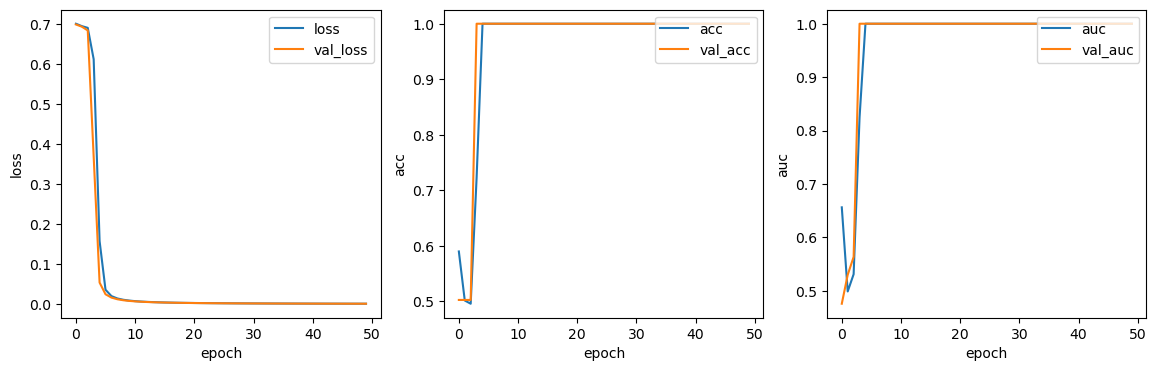

In [43]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [44]:
pred_proba_test, pred_test = eval_metrics(model)

test set
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2010
         1.0       1.00      1.00      1.00      1990

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [45]:
log_to_wandb(y_test, pred_proba_test, pred_test)

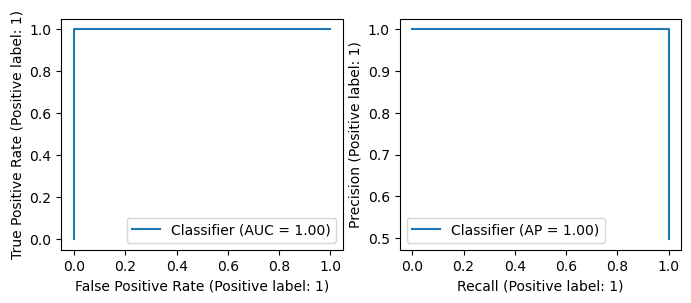

In [46]:
plot_roc_pr_curves(pred_proba_test, y_test[:,1]);

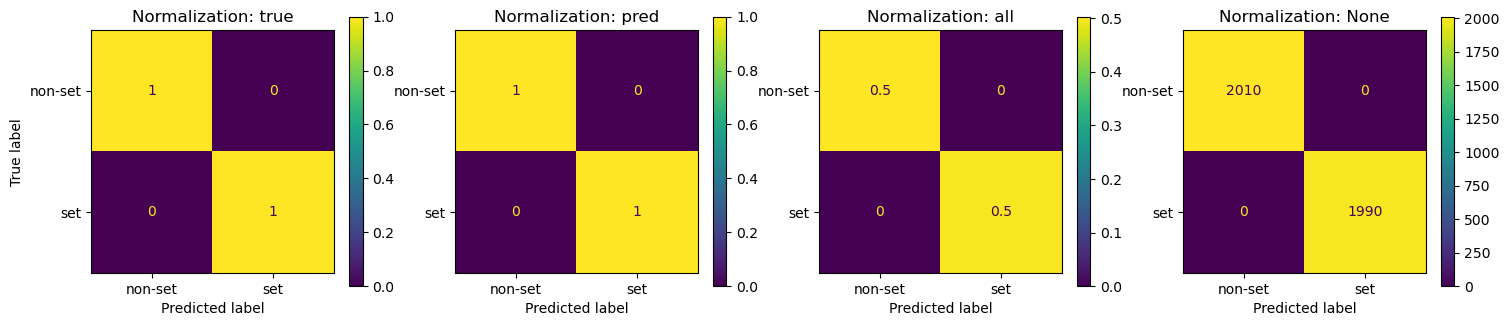

In [47]:
plot_confusion_matrices(y_test[:,1], pred_test);

In [48]:
wandb.finish()

acc,▂▁▁▄████████████████████████████████████
auc,▃▁▁▆████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,███▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▂▁▁▅████████████████████████████████████
recall,▄▁▁▄████████████████████████████████████
val_acc,▁▁▁█████████████████████████████████████
val_auc,▁▂▂█████████████████████████████████████
val_loss,███▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▁▁█████████████████████████████████████
val_recall,▁▁▁█████████████████████████████████████


In [49]:
# examine learned groups
glayer.weights

[<tf.Variable 'group_layer/group_0_logit:0' shape=(6, 1) dtype=float32, numpy=
 array([[-2.8176308],
        [-2.6920123],
        [-3.0697565],
        [-2.8425891],
        [ 3.7048857],
        [ 3.704783 ]], dtype=float32)>,
 <tf.Variable 'group_layer/group_1_logit:0' shape=(6, 1) dtype=float32, numpy=
 array([[ 3.5005765],
        [ 3.4978528],
        [-1.4949608],
        [-1.5174054],
        [-2.99719  ],
        [-3.1744432]], dtype=float32)>,
 <tf.Variable 'group_layer/group_2_logit:0' shape=(6, 1) dtype=float32, numpy=
 array([[ 2.8958933],
        [ 2.8953   ],
        [-2.1321535],
        [-2.0090876],
        [-2.4587443],
        [-2.4644053]], dtype=float32)>]

### RelNN with Grouping Layer and Composition

In [50]:
run = wandb.init(project='RelNN-RMTS', group='RelNN (w Grouping Layer + Composition)', save_code=True)

input_ = tf.keras.layers.Input(shape=(6, 4), name='input_seq')

encoder_constructors = [LinearProjectionEncoder]*4
rel_layer = RelationalLayer(encoder_constructors, name='rel_layer')
x = rel_layer(input_)

glayer = GroupLayer(num_groups=3, name='group_layer')
x = glayer(x)

# x = RelInnerProduct(name='rel_inner_prod2')(x)
encoder_constructors = [LinearProjectionEncoder]*4
rel_layer = RelationalLayer(encoder_constructors, name='rel_layer2')
x = rel_layer(x)

x = FlattenTriangular(include_diag=False, name='flatten_tri')(x)

x = tf.keras.layers.Dense(16, activation='relu', name='dense1')(x)
x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

model = tf.keras.Model(input_, x, name='RelNN_w_Grouping_Composition')

my_logits = [
  np.transpose([[1, 1, -1, -1, -1, -1]]),
  np.transpose([[-1, -1, 1, 1, -1, -1]]),
  np.transpose([[-1, -1, -1, -1, 1, 1]])
]

glayer.set_weights(my_logits)

model.summary()

Model: "RelNN_w_Grouping_Composition"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_seq (InputLayer)      [(None, 6, 4)]            0         
                                                                 
 rel_layer (RelationalLayer)  (None, 6, 6, 4)          16        
                                                                 
 group_layer (GroupLayer)    (None, 3, 4)              18        
                                                                 
 rel_layer2 (RelationalLayer  (None, 3, 3, 4)          16        
 )                                                               
                                                                 
 flatten_tri (FlattenTriangu  (None, 12)               0         
 lar)                                                            
                                                                 
 dense1 (Dense)              (None, 16

In [51]:
model.compile(loss=loss, optimizer=opt, metrics=metrics)

history = model.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), **fit_kwargs)

Epoch 1/50
40/40 [==============================] - 83s 2s/step - loss: 0.6902 - acc: 0.5847 - precision: 0.5853 - recall: 0.5657 - auc: 0.6478 - val_loss: 0.6781 - val_acc: 0.5245 - val_precision: 1.0000 - val_recall: 0.0442 - val_auc: 0.5183
Epoch 2/50
40/40 [==============================] - 21s 522ms/step - loss: 0.6829 - acc: 0.5089 - precision: 0.5161 - recall: 0.1999 - auc: 0.5087 - val_loss: 0.6777 - val_acc: 0.5245 - val_precision: 1.0000 - val_recall: 0.0442 - val_auc: 0.5221
Epoch 3/50
40/40 [==============================] - 20s 511ms/step - loss: 0.6826 - acc: 0.5069 - precision: 0.5148 - recall: 0.1472 - auc: 0.5061 - val_loss: 0.6778 - val_acc: 0.5245 - val_precision: 1.0000 - val_recall: 0.0442 - val_auc: 0.5221
Epoch 4/50
40/40 [==============================] - 20s 498ms/step - loss: 0.6825 - acc: 0.5059 - precision: 0.5137 - recall: 0.1211 - auc: 0.5102 - val_loss: 0.6777 - val_acc: 0.5245 - val_precision: 1.0000 - val_recall: 0.0442 - val_auc: 0.5221
Epoch 5/50
40/4

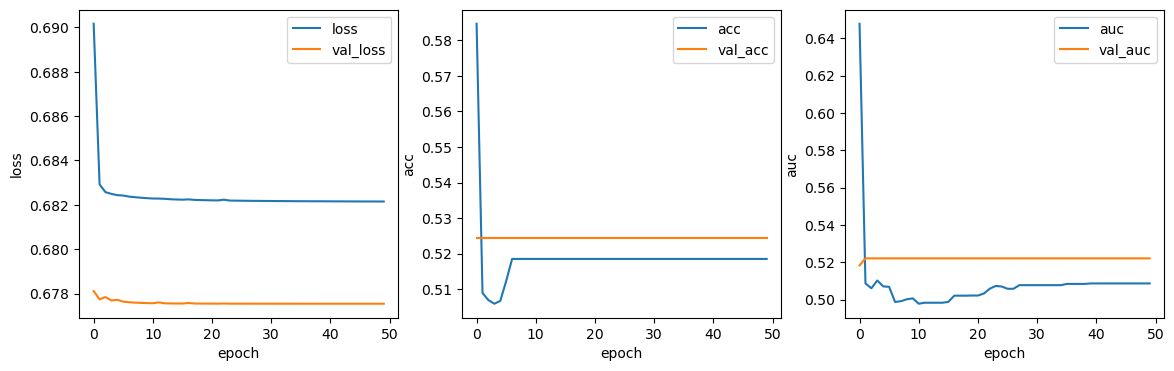

In [52]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [53]:
pred_proba_test, pred_test = eval_metrics(model)

test set
              precision    recall  f1-score   support

         0.0       0.51      1.00      0.68      2010
         1.0       1.00      0.03      0.06      1990

    accuracy                           0.52      4000
   macro avg       0.76      0.52      0.37      4000
weighted avg       0.75      0.52      0.37      4000



In [54]:
log_to_wandb(y_test, pred_proba_test, pred_test)

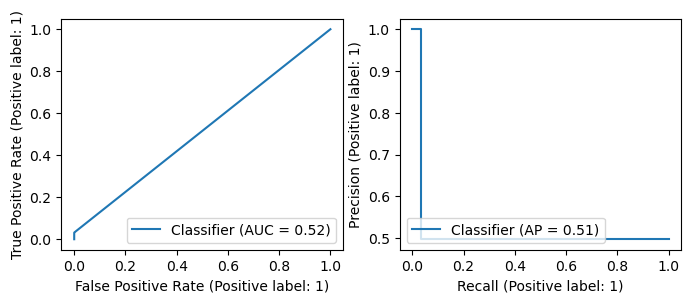

In [55]:
plot_roc_pr_curves(pred_proba_test, y_test[:,1]);

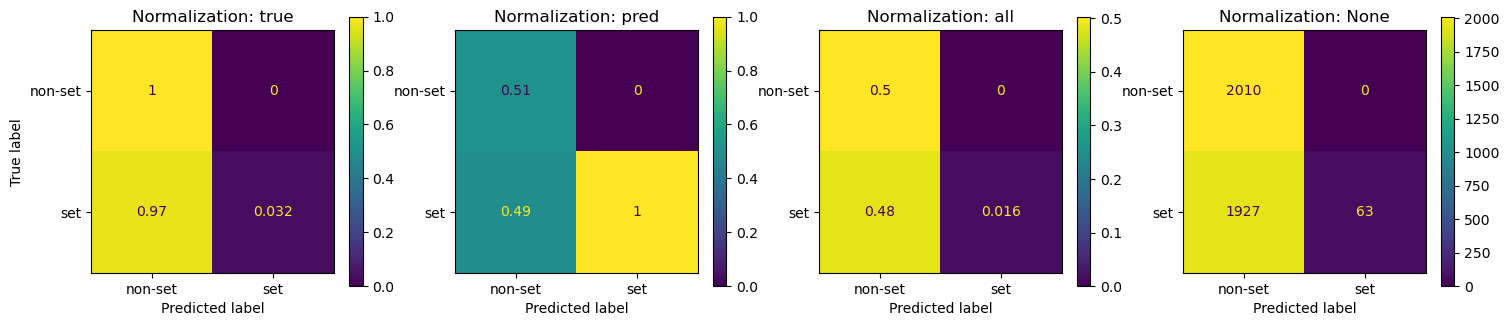

In [56]:
plot_confusion_matrices(y_test[:,1], pred_test);

In [57]:
wandb.finish()

acc,█▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
auc,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▂▁▁▁▂███████████████████████████████████
recall,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_auc,▁███████████████████████████████████████
val_loss,█▃▅▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [58]:
# examine learned groups
glayer.weights

[<tf.Variable 'group_layer/group_0_logit:0' shape=(6, 1) dtype=float32, numpy=
 array([[ 1.2408503 ],
        [ 1.3714616 ],
        [-1.1696233 ],
        [-1.6306862 ],
        [-0.07016308],
        [ 0.89815956]], dtype=float32)>,
 <tf.Variable 'group_layer/group_1_logit:0' shape=(6, 1) dtype=float32, numpy=
 array([[-0.3952576 ],
        [-0.16709074],
        [ 1.3073136 ],
        [ 1.0289222 ],
        [-0.29630637],
        [ 0.28366876]], dtype=float32)>,
 <tf.Variable 'group_layer/group_2_logit:0' shape=(6, 1) dtype=float32, numpy=
 array([[ 0.39227098],
        [ 0.5453879 ],
        [-1.4843577 ],
        [-1.7651199 ],
        [ 1.5715351 ],
        [ 1.1959614 ]], dtype=float32)>]